# Data cleaning

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load csv
jfk = pd.read_csv('/content/JFK_flight_data.csv')

# Drop null values
jfk = jfk.dropna()

# One-hot encoding for categorical variables
one_hot = pd.get_dummies(jfk['OP_UNIQUE_CARRIER'])
jfk = jfk.drop('OP_UNIQUE_CARRIER',axis = 1)
jfk = jfk.join(one_hot)

one_hot = pd.get_dummies(jfk['DEST'])
jfk = jfk.drop('DEST',axis = 1)
jfk = jfk.join(one_hot)

one_hot = pd.get_dummies(jfk['Wind'])
jfk = jfk.drop('Wind',axis = 1)
jfk = jfk.join(one_hot)

one_hot = pd.get_dummies(jfk['Condition'])
jfk = jfk.drop('Condition',axis = 1)
jfk = jfk.join(one_hot)

jfk.loc[jfk['MONTH']==1, 'MONTH'] = 'Jan'
jfk.loc[jfk['MONTH']==11, 'MONTH'] = 'Nov'
jfk.loc[jfk['MONTH']==12, 'MONTH'] = 'Dec'
one_hot = pd.get_dummies(jfk['MONTH'])
jfk = jfk.drop('MONTH', axis = 1)
jfk = jfk.join(one_hot)

# Drop unneeded columns
jfk = jfk.drop(columns = ['TAIL_NUM','DEP_TIME_M'])

# Change type of Dew Point column to int
jfk['Dew Point'] = jfk['Dew Point'].astype(int)

In [3]:
# Turn target column into a categorical variable based on whether the departure
#     delay is 15 minutes or more.

jfk['DEP_DELAY_CAT'] = jfk['DEP_DELAY'].apply(lambda x: 1 if x > 15 else 0)

# Drop original departure delay column

jfk = jfk.drop('DEP_DELAY', axis = 1)

# Train-test-validation split

In [4]:
# Train test validation split 

# Train-test split
from sklearn.model_selection import train_test_split

X,y = jfk.loc[:, jfk.columns != 'DEP_DELAY_CAT'], jfk.loc[:, 'DEP_DELAY_CAT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=604)

# Train-validation split

X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 604)

In [16]:
# Stratified k-fold cross validation split
# Keeps same percentage of samples for each class

from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(5,
                        shuffle=True,
                        random_state = 604)

i = 1

for train_index, test_index in kfold.split(X_train,y_train):
    print("Split",i)
    print("CV Training Set Split")
    print(y_train.iloc[train_index].value_counts(normalize=True))
    
    print()
    
    print("CV Validation Set Split")
    print(y_train.iloc[test_index].value_counts(normalize=True))
    
    print("+++++++++++++++")
    i = i + 1

Split 1
CV Training Set Split
0    0.868405
1    0.131595
Name: DEP_DELAY_CAT, dtype: float64

CV Validation Set Split
0    0.868358
1    0.131642
Name: DEP_DELAY_CAT, dtype: float64
+++++++++++++++
Split 2
CV Training Set Split
0    0.868405
1    0.131595
Name: DEP_DELAY_CAT, dtype: float64

CV Validation Set Split
0    0.868358
1    0.131642
Name: DEP_DELAY_CAT, dtype: float64
+++++++++++++++
Split 3
CV Training Set Split
0    0.868405
1    0.131595
Name: DEP_DELAY_CAT, dtype: float64

CV Validation Set Split
0    0.868358
1    0.131642
Name: DEP_DELAY_CAT, dtype: float64
+++++++++++++++
Split 4
CV Training Set Split
0    0.868405
1    0.131595
Name: DEP_DELAY_CAT, dtype: float64

CV Validation Set Split
0    0.868358
1    0.131642
Name: DEP_DELAY_CAT, dtype: float64
+++++++++++++++
Split 5
CV Training Set Split
0    0.868358
1    0.131642
Name: DEP_DELAY_CAT, dtype: float64

CV Validation Set Split
0    0.868547
1    0.131453
Name: DEP_DELAY_CAT, dtype: float64
+++++++++++++++


# Logistic regression

## First model without stratified k-fold cv

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Fit a basic logistic regression model

log_reg = LogisticRegression(penalty = None, max_iter = 10000)
log_model = log_reg.fit(X_train_train, y_train_train)
log_pred = log_model.predict(X_val)

log_score = log_model.score(X_val, y_val)

print(log_score)


0.8703101279548905


In [7]:
# Print confusion matrices

# Confusion matrix for the training set
print('Confusion matrix for training set')
print(confusion_matrix(y_train_train, log_model.predict(X_train_train)))

# Confusion matrix for the validation set
# Default cutoff of 0.5
print('Confusion matrix for validation set, cutoff 0.5')
print(confusion_matrix(y_val, log_pred))

# Confusion matrix for validation set and a cutoff of 0.4
print('Confusion matrix for validation set, cutoff 0.4')
print(confusion_matrix(y_val, np.int64(log_reg.predict_proba(X_val)[:,1] >= 0.4)))


Confusion matrix for training set
[[15982    31]
 [ 2335    95]]
Confusion matrix for validation set, cutoff 0.5
[[3999    8]
 [ 590   14]]
Confusion matrix for validation set, cutoff 0.4
[[3963   44]
 [ 563   41]]


Confusion Matrix for Logistic Regression
[[3999    8]
 [ 590   14]]


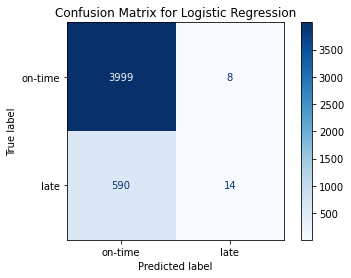

In [8]:
# Confusion matrix display on validation set, cutoff 0.5

from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_estimator(
        log_model,
        X_val,
        y_val,
        display_labels=['on-time','late'],
        cmap=plt.cm.Blues
    )
disp.ax_.set_title('Confusion Matrix for Logistic Regression')

print('Confusion Matrix for Logistic Regression')
print(disp.confusion_matrix)

## Determine cutoff point with stratified cv

In [37]:
# Compute accuracy, precision, recall, and f1 score for different cutoff points
#  using stratified k-fold cross-validation splits

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

i = 0
cutoffs = np.arange(0.01,.95,.001)
accuracy_scores = np.zeros((5, len(cutoffs)))
precision_scores = np.zeros((5, len(cutoffs)))
recall_scores = np.zeros((5, len(cutoffs)))
f1_scores = np.zeros((5, len(cutoffs)))

 
for train_index, test_index in kfold.split(X_train,y_train):
    j=0
    log_reg_i = LogisticRegression(penalty = None, max_iter = 10000)
    log_model_i = log_reg.fit(X_train.iloc[train_index], y_train.iloc[train_index])
    log_pred_i = log_model.predict(X_train.iloc[test_index])

    y_pred_prob_i = log_model_i.predict_proba(X_train.iloc[test_index])[:,1]

    for cutoff in cutoffs:
      pred = 1*(y_pred_prob_i >= cutoff)

      accuracy_scores[i,j] = accuracy_score(y_train.iloc[test_index], pred)

      precision_scores[i,j] = precision_score(y_train.iloc[test_index], pred, zero_division=1)

      recall_scores[i,j] = recall_score(y_train.iloc[test_index], pred, zero_division=1)

      f1_scores[i,j] = f1_score(y_train.iloc[test_index], pred, zero_division = 1)

      j+= 1
    
    i += 1

In [38]:
# Get average scores over all cv splits

acc_scores_avg = []
precision_scores_avg = []
recall_scores_avg = []
f1_scores_avg = []
for i in range(len(cutoffs)):
  acc_scores_avg.append(np.average(accuracy_scores[:,i]))
  precision_scores_avg.append(np.average(precision_scores[:,i]))
  recall_scores_avg.append(np.average(recall_scores[:,i]))
  f1_scores_avg.append(np.average(f1_scores[:,i]))

In [39]:
cutoff_arg = np.argmax(f1_scores_avg)
cutoff = cutoff_arg*0.001+0.01

print(cutoff_arg)
print('the maximum f1 score is', np.max(f1_scores_avg))
print('the cutoff value for the max f1 score is',cutoff)
print('\n')
print('the precision for the maximum f1 score is', precision_scores_avg[cutoff_arg])
print('the recall for the maximum f1 score is', recall_scores_avg[cutoff_arg])
print('the accuracy for the maximum f1 score is', acc_scores_avg[cutoff_arg])

167
the maximum f1 score is 0.3298579705385655
the cutoff value for the max f1 score is 0.17700000000000002


the precision for the maximum f1 score is 0.2595485922371156
the recall for the maximum f1 score is 0.45254049292902937
the accuracy for the maximum f1 score is 0.7580026354031268


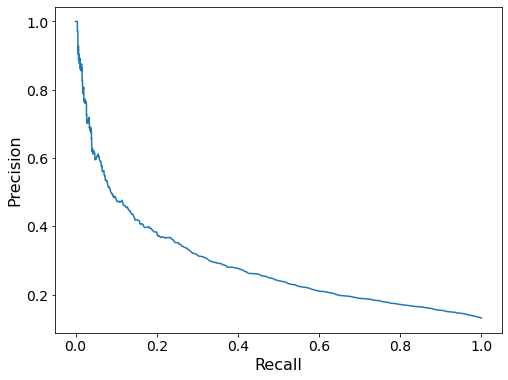

In [33]:
# Precision-recall curve from cross-validation

plt.figure(figsize=(8,6))

plt.plot(recall_scores_avg, precision_scores_avg)

plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

In [31]:
# Confusion matrix, precision, recall, and f1 scores for the test set

from sklearn.metrics import confusion_matrix

log_reg = LogisticRegression(penalty = None, max_iter=10000)
log_model = log_reg.fit(X_train, y_train)
log_pred = log_model.predict_proba(X_test)
log_pred_cutoff = np.int64(1*(log_pred[:,1] >= cutoff))

print('Confusion matrix for the test set, cutoff', cutoff)
print(confusion_matrix(y_test, log_pred_cutoff))

print('Precision score is', precision_score(y_test, log_pred_cutoff, zero_division=1))
print('Recall score is', recall_score(y_test, log_pred_cutoff, zero_division=1))
print('F1 score is', f1_score(y_test, log_pred_cutoff, zero_division=1))

Confusion matrix for the test set, cutoff 0.17700000000000002
[[3942  983]
 [ 499  340]]
Precision score is 0.25699168556311414
Recall score is 0.4052443384982122
F1 score is 0.3145235892691952


Confusion Matrix for Logistic Regression




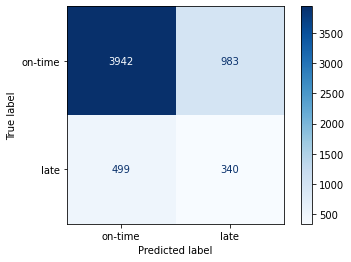

In [32]:
# Display the confusion matrix for the test set

from sklearn.metrics import ConfusionMatrixDisplay

print('Confusion Matrix for Logistic Regression')
print('\n')

ConfusionMatrixDisplay.from_predictions(y_test, log_pred_cutoff, 
                                        display_labels=['on-time','late'], 
                                        cmap=plt.cm.Blues)

In [ ]:
# Ways to improve: tune hyperparameter C, which inversely affects the weight of regularization;
#   use l1 or l2 or elasticnet regularization;
#   may want to weigh precision more, since it may be worse to
#   label an on-time flight as delayed than the reverse;
#   can try other log solvers and use gridsearchcv to find best combination of parameters